In [1]:
import random
import pandas as pd
import networkx as nx
import markov_clustering as mc
import matplotlib.pyplot as plt

In [3]:
def plot_dataset(file_name):
    '''
    Plot the network x graph for the models
    '''
    df_e = pd.read_parquet(file_name)
    G = nx.from_pandas_edgelist(df_e, 'from', 'to')
    sub_G = list(nx.dfs_edges(G))
    print("Number of Nodes:", len(sub_G)+1)

    nodes = [list(t) for t in zip(*sub_G)]
    sub_graph = G.subgraph(set(nodes[0] + nodes[1]))

    matrix = nx.to_scipy_sparse_array(sub_graph)
    matrix = matrix.toarray()
    
    result = mc.run_mcl(matrix)
    clusters = mc.get_clusters(result)
    
    print("number of clusters:", len(clusters))
    print("number of nodes in each cluster:", [len(c) for c in clusters])

    plt.figure(figsize=(25, 25))
    mc.draw_graph(matrix, clusters, node_size=60, with_labels=False, edge_color="silver")

Number of Nodes: 151
number of clusters: 22
number of nodes in each cluster: [82, 3, 4, 4, 3, 3, 5, 3, 4, 4, 4, 2, 2, 3, 3, 4, 3, 2, 5, 3, 4, 2]


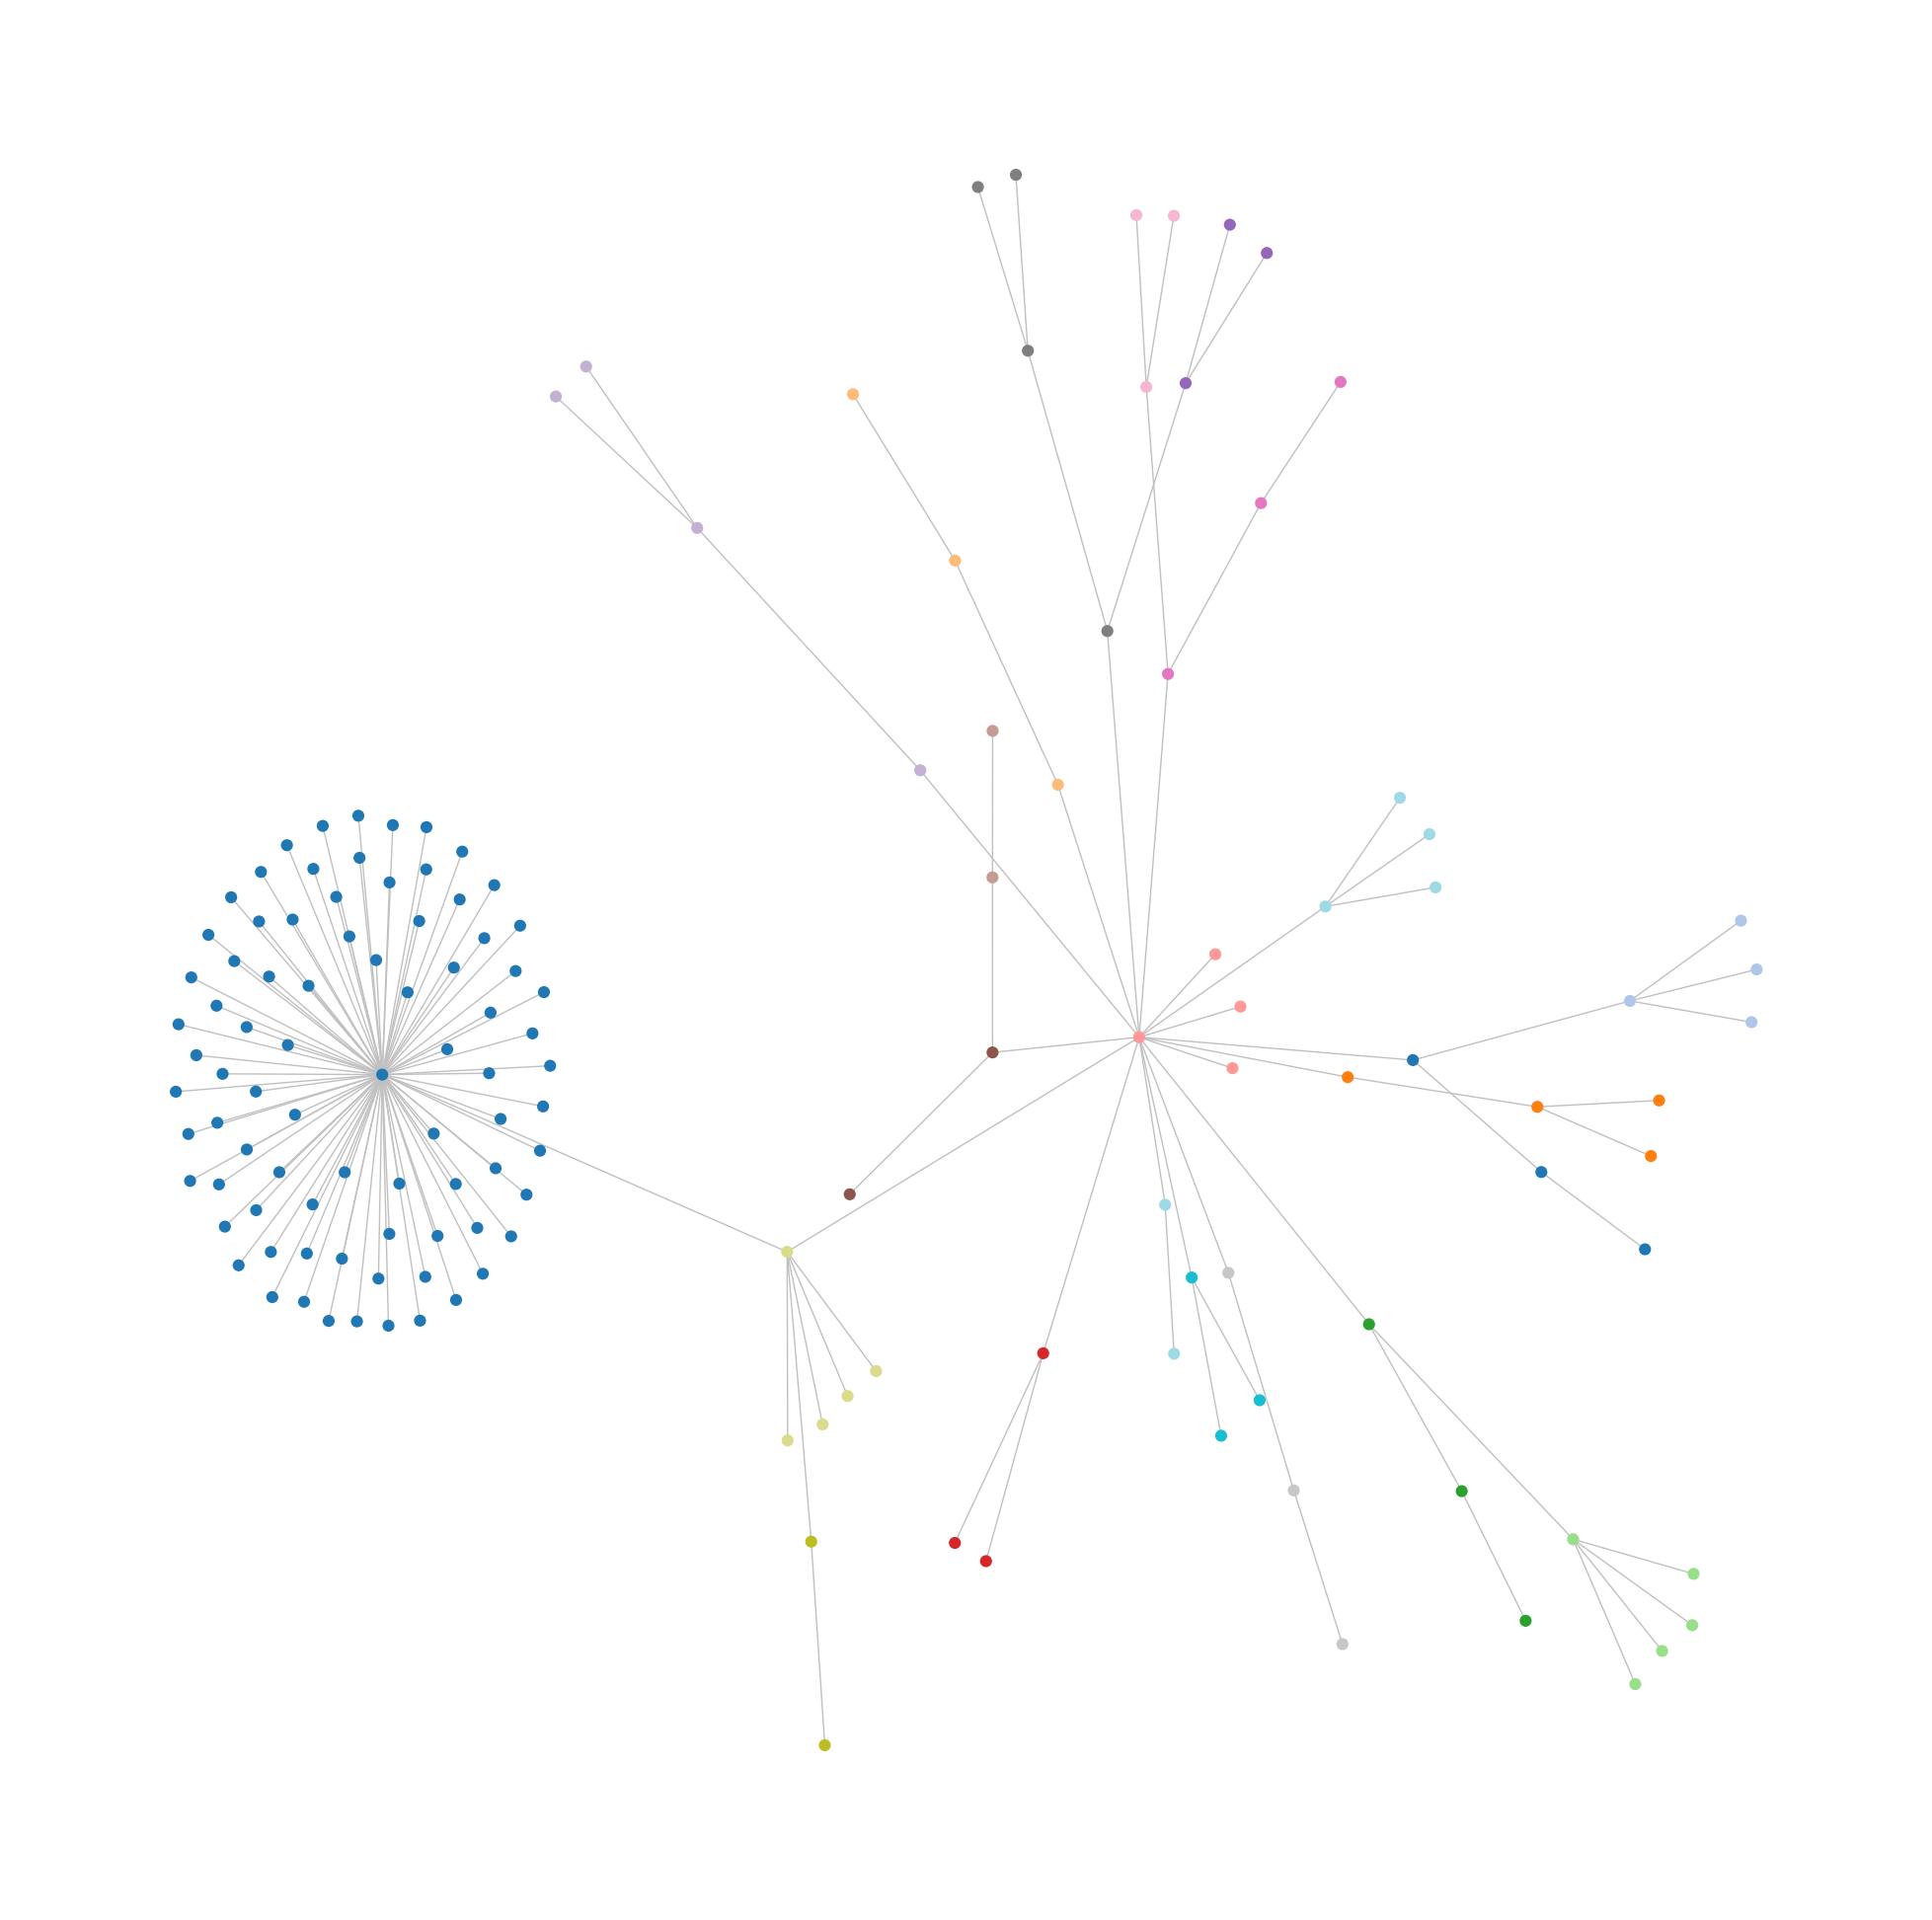

In [32]:
plot_dataset(file_name="./data/datasetBFS/cache/edges/edges_2.parquet")

Number of Nodes: 151
number of clusters: 58
number of nodes in each cluster: [2, 3, 2, 2, 2, 4, 4, 2, 4, 1, 4, 3, 3, 2, 2, 2, 2, 4, 3, 3, 3, 4, 2, 2, 2, 3, 4, 2, 3, 2, 2, 2, 5, 4, 2, 2, 2, 3, 3, 3, 4, 2, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2]


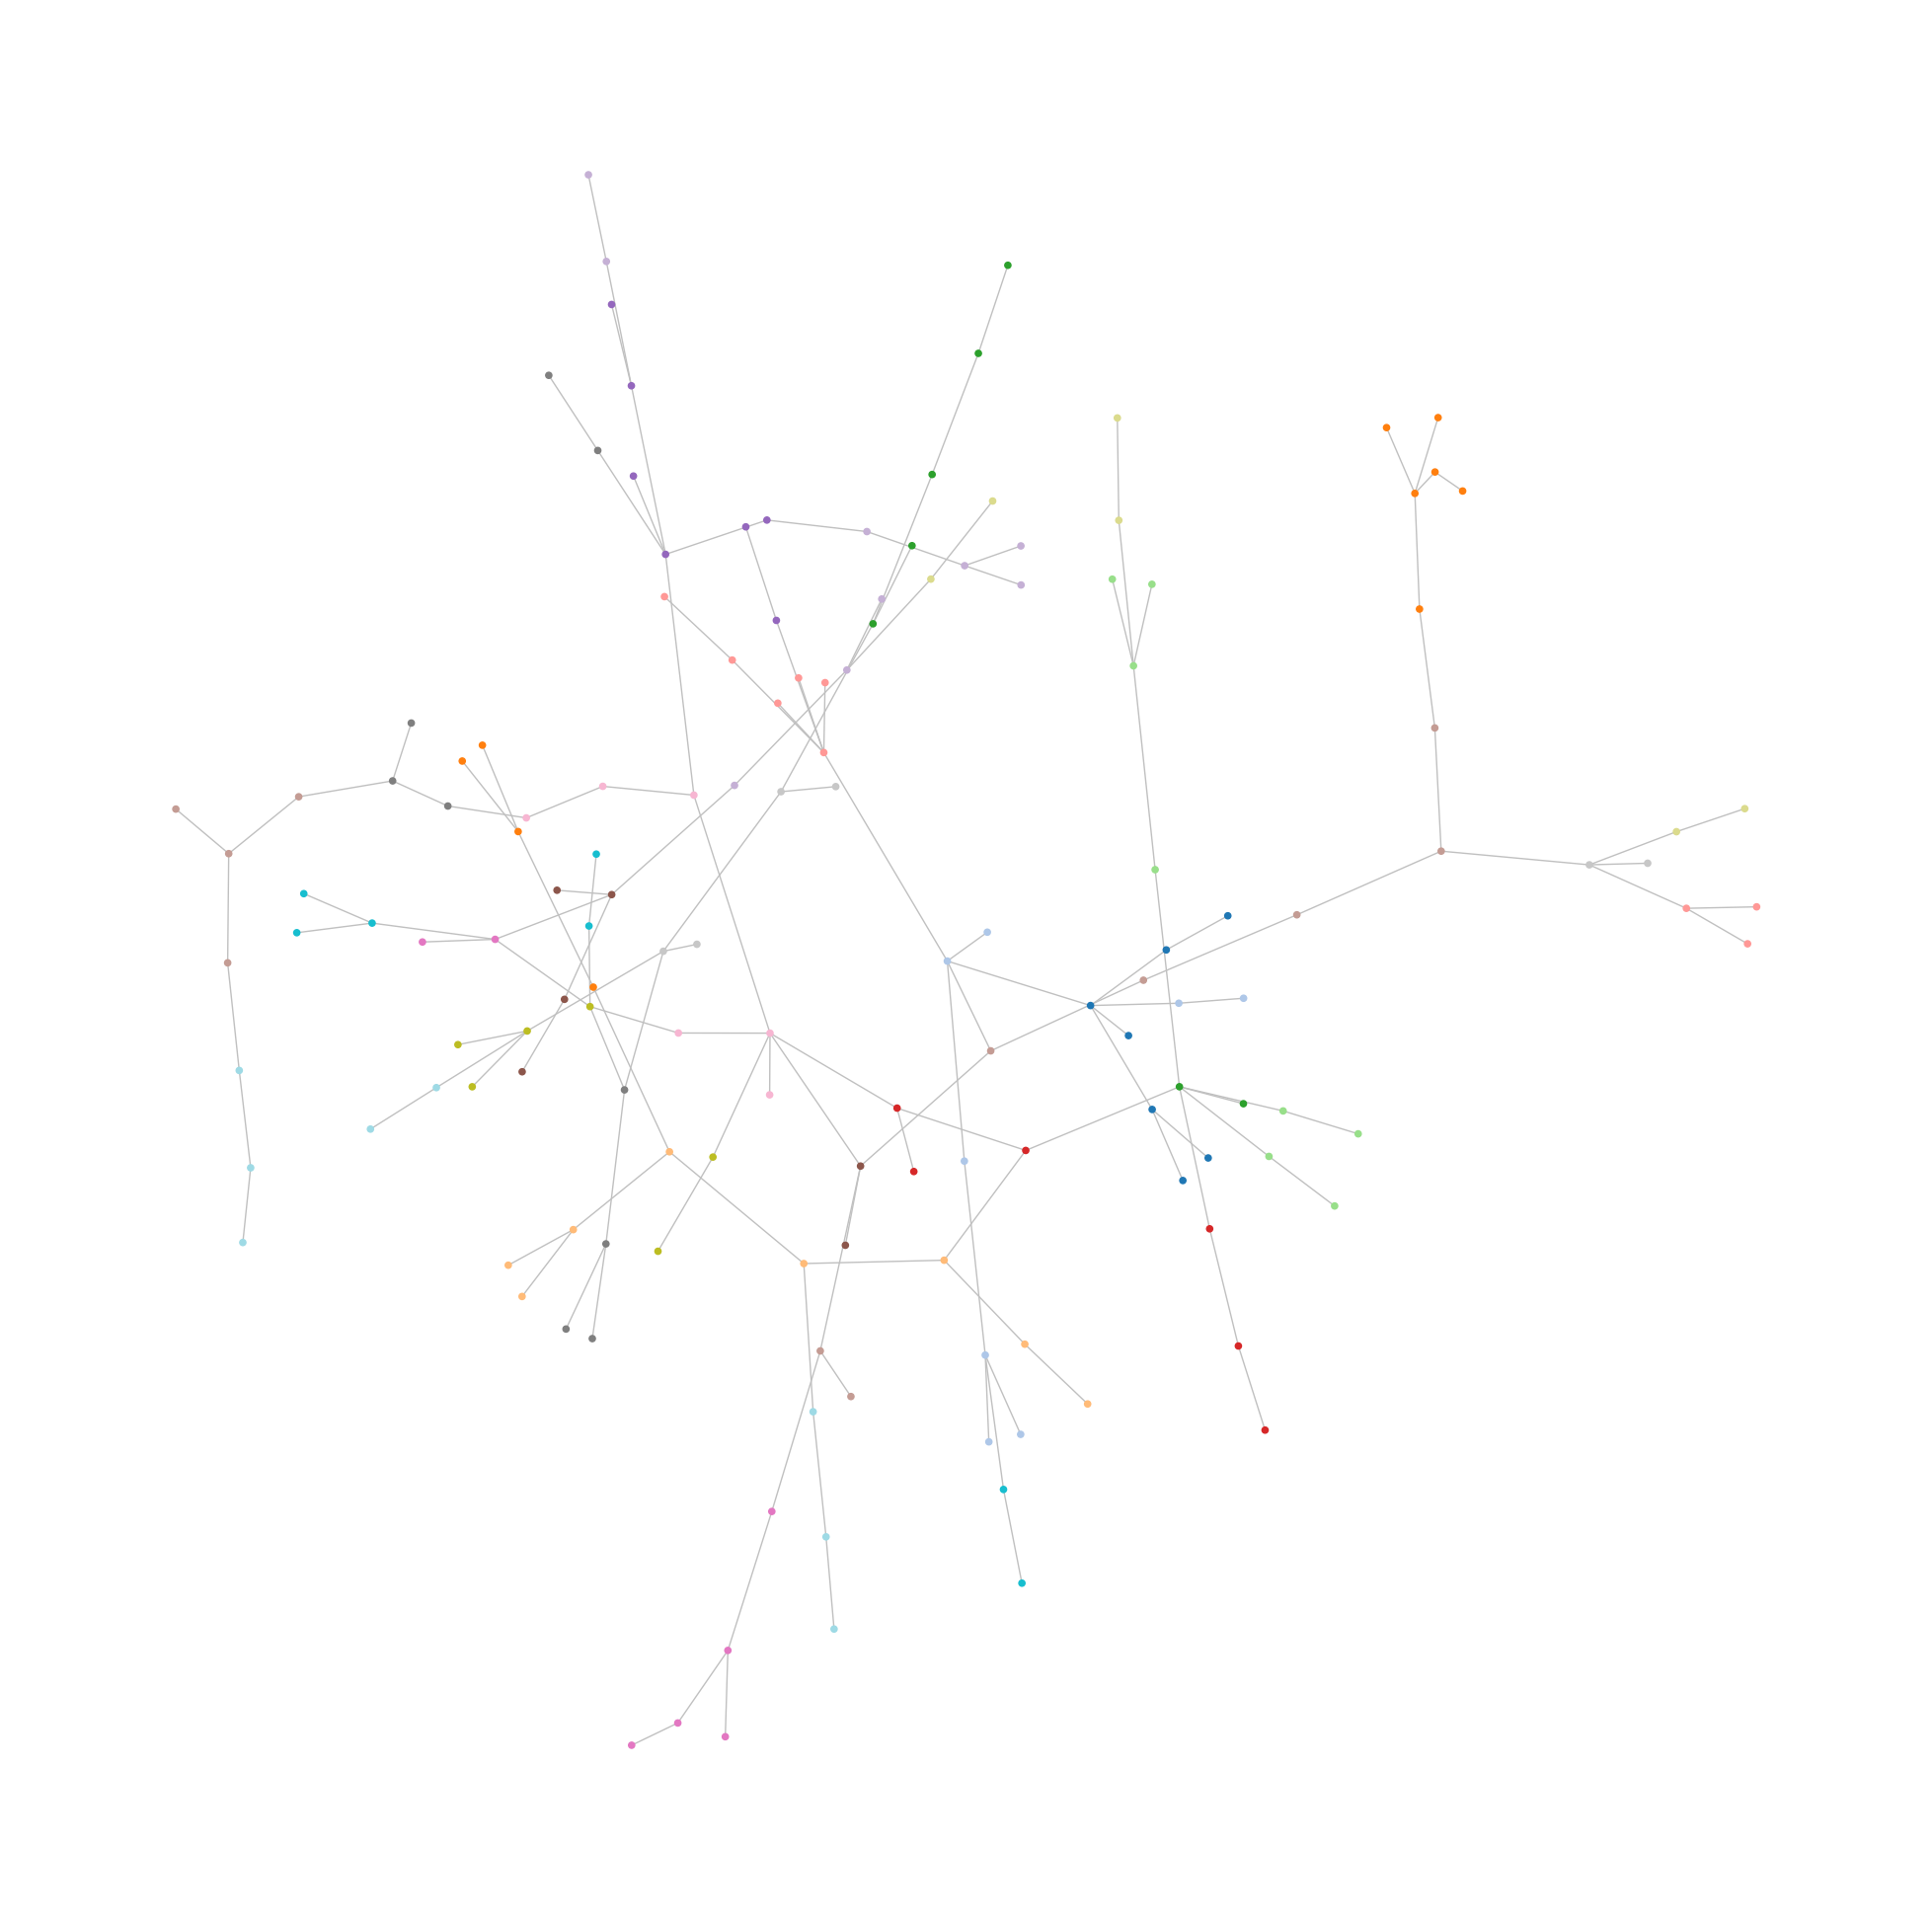

In [23]:
plot_dataset(file_name="./data/datasetRFS/cache/edges/edges_2.parquet")

Number of Nodes: 150
number of clusters: 45
number of nodes in each cluster: [3, 4, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 2, 4, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 1, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4]


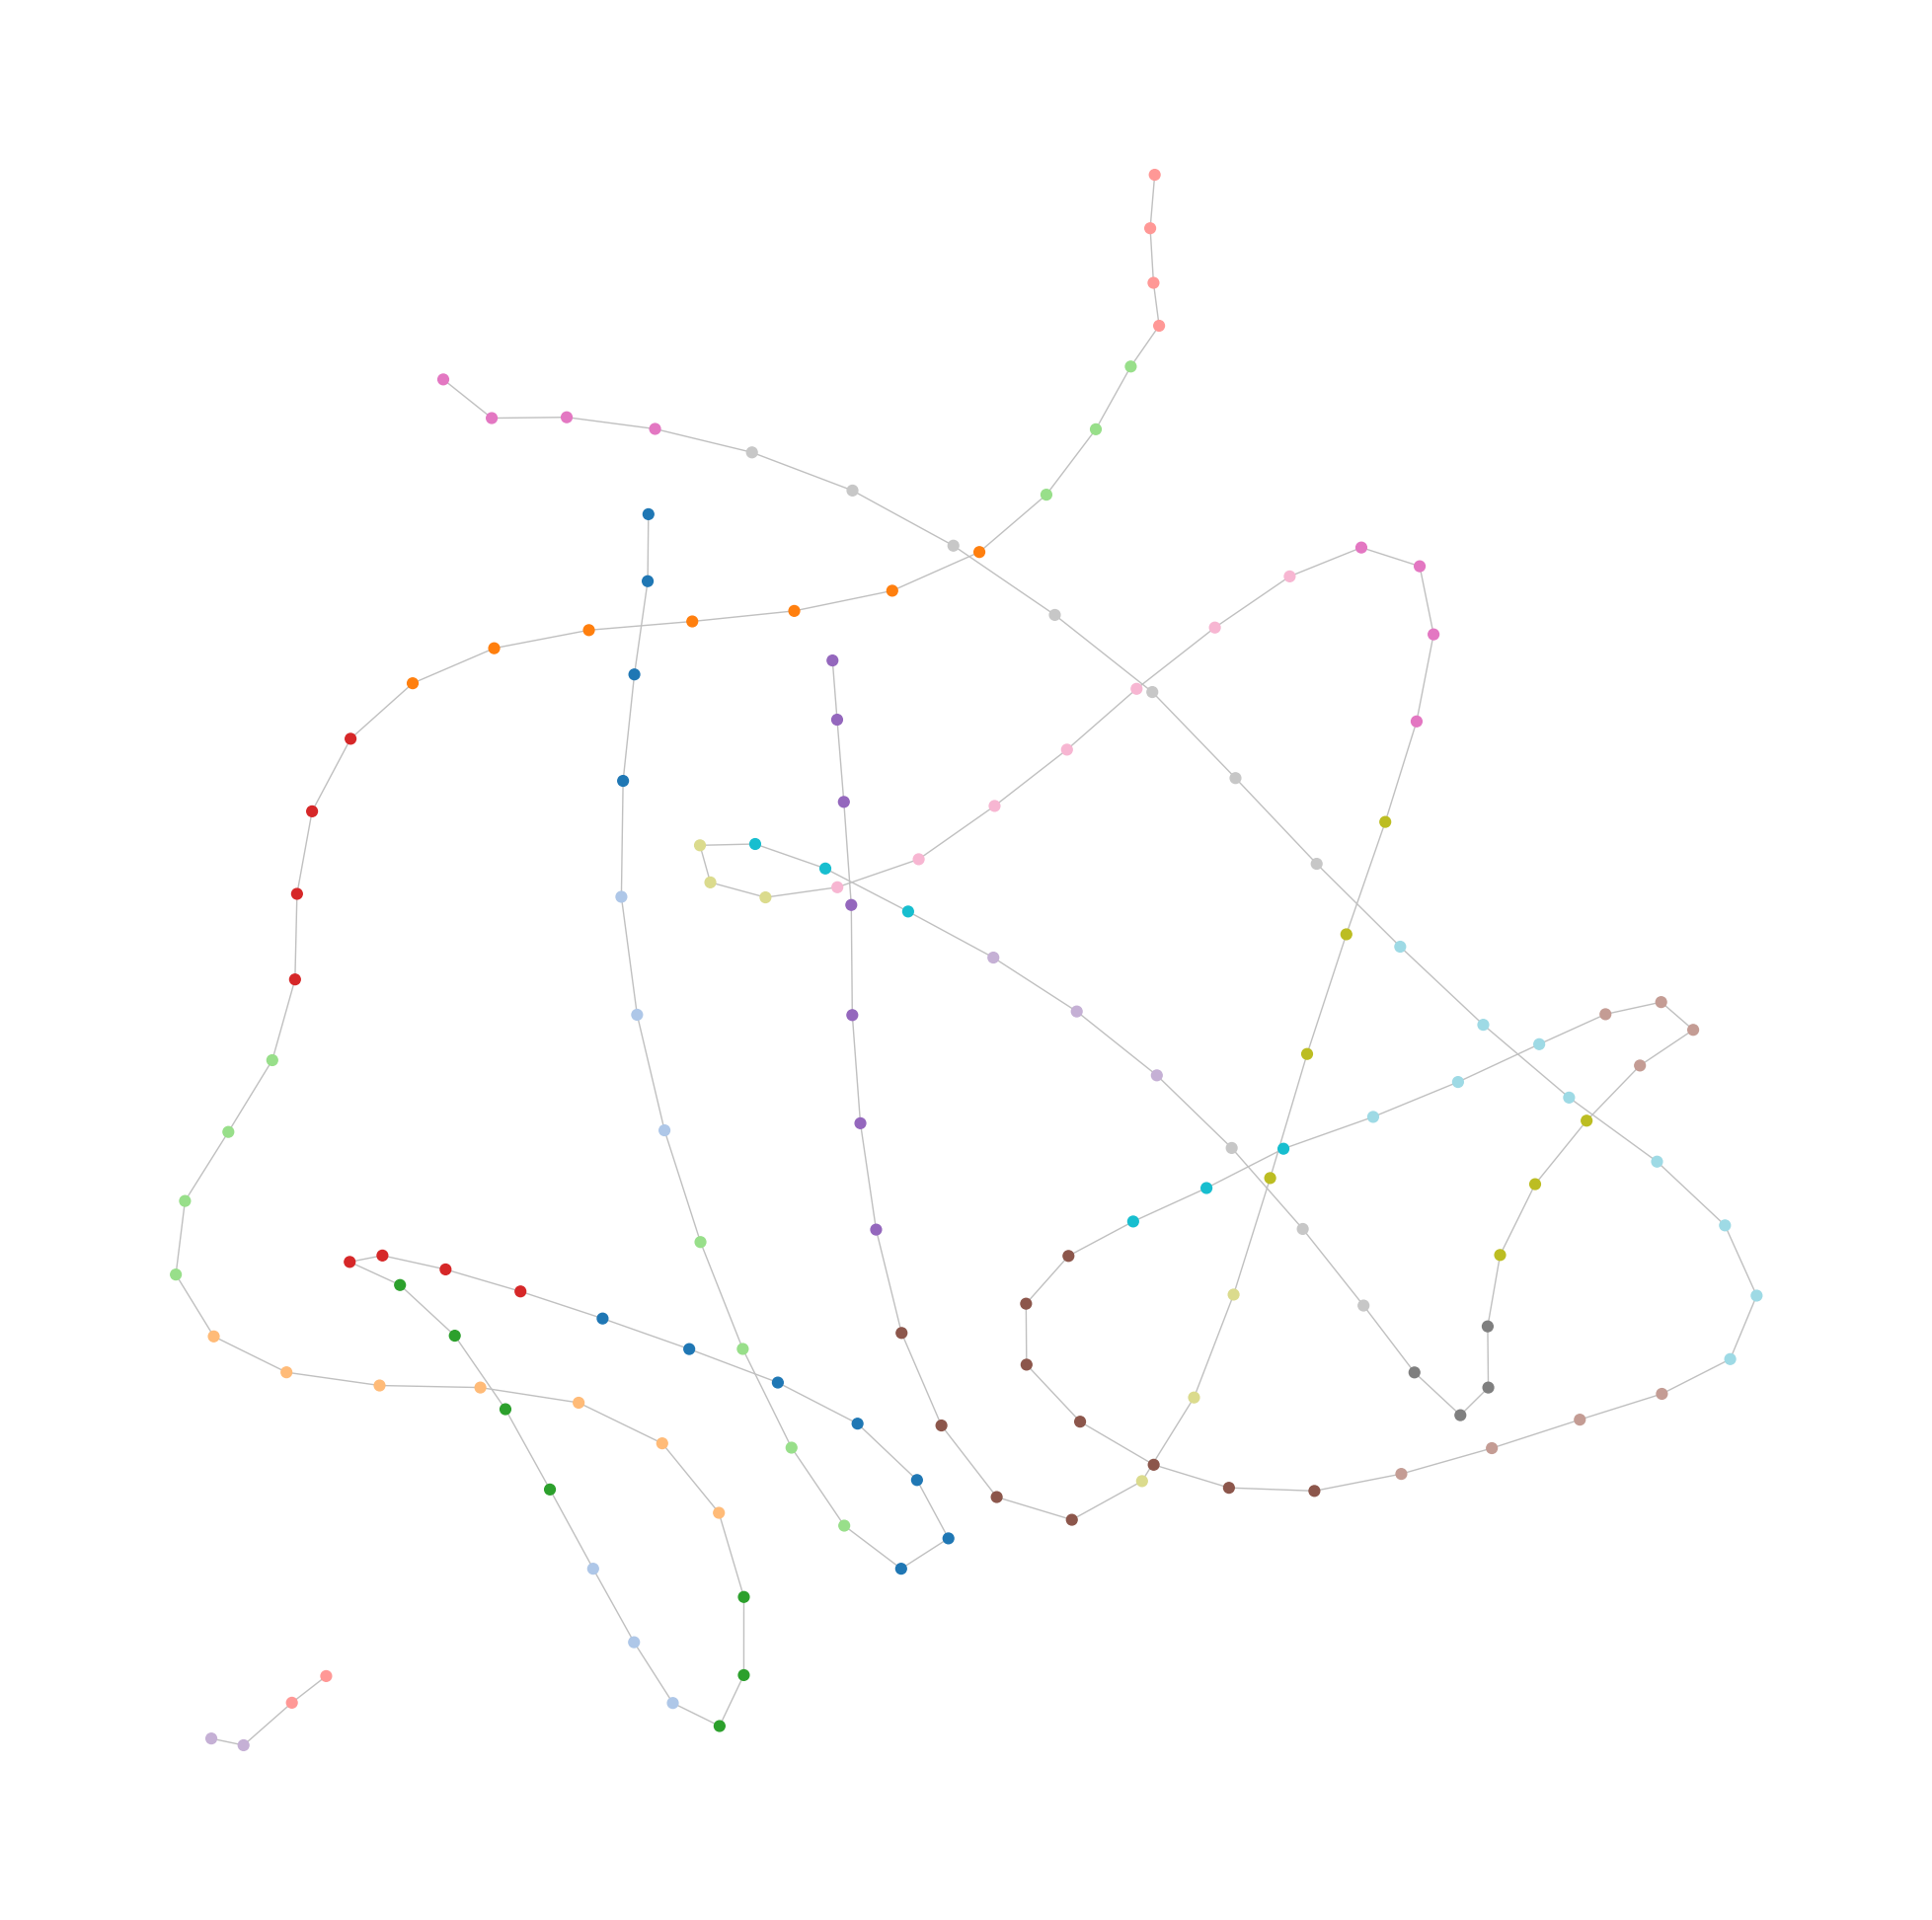

In [5]:
plot_dataset(file_name="./data/datasetMHRW/cache/edges/edges_5.parquet")

In [23]:
import numpy as np
import sknetwork
import sknetwork.data as ds
from sknetwork.clustering import Louvain
import networkx as nx
import pandas as pd
from typing import Dict, List, Tuple, Union
from scipy import sparse
from sknetwork.linalg.sparse_lowrank import SparseLR

In [26]:
class Bunch(dict):
    """Container object for datasets.
    Dictionary-like object that exposes its keys as attributes.
    >>> dataset = Bunch(name='dataset')
    >>> dataset['name']
    'dataset'
    >>> dataset.name
    'dataset'
    """
    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)
            
def from_edge_array(edge_array: np.ndarray, weights: np.ndarray = None, directed: bool = False, bipartite: bool = False,
                    weighted: bool = True, reindex: bool = True, sum_duplicates: bool = True,
                    matrix_only: bool = None) -> Union[Bunch, sparse.csr_matrix]:
    """Load a graph from an edge array of shape (n_edges, 2) and weights (optional).

    Parameters
    ----------
    edge_array : np.ndarray
        Array of edges.
    weights : np.ndarray
        Array of weights.
    directed : bool
        If ``True``, considers the graph as directed.
    bipartite : bool
        If ``True``, returns a biadjacency matrix.
    weighted : bool
        If ``True``, returns a weighted graph.
    reindex : bool
        If ``True``, reindex nodes and returns the original node indices as names.
        Reindexing is enforced if nodes are not integers.
    sum_duplicates : bool
        If ``True`` (default), sums weights of duplicate edges.
        Otherwise, the weight of each edge is that of the first occurrence of this edge.
    matrix_only : bool
        If ``True``, returns only the adjacency or biadjacency matrix.
        Otherwise, returns a ``Dataset`` object with graph attributes (e.g., node names).
        If not specified (default), selects the most appropriate format.

    Returns
    -------
    graph : :class:`Dataset` or sparse matrix
    """
    try:
        edge_array = edge_array.astype(float)
    except ValueError:
        pass
    if edge_array.dtype == float and (edge_array == edge_array.astype(int)).all():
        edge_array = edge_array.astype(int)
    if weights is None:
        weights = np.ones(len(edge_array))
    if weights.dtype not in [bool, int, float]:
        try:
            weights = weights.astype(float)
        except ValueError:
            raise ValueError('Weights must be numeric.')
    if all(weights == weights.astype(int)):
        weights = weights.astype(int)
    if not weighted:
        weights = weights.astype(bool)

    if not sum_duplicates:
        _, index = np.unique(edge_array, axis=0, return_index=True)
        edge_array = edge_array[index]
        weights = weights[index]
    graph = Bunch()
    if bipartite:
        row = edge_array[:, 0]
        col = edge_array[:, 1]
        if row.dtype != int or (reindex and len(set(row)) < max(row) + 1):
            names_row, row = np.unique(row, return_inverse=True)
            graph.names_row = names_row
            graph.names = names_row
            n_row = len(names_row)
        else:
            n_row = max(row) + 1
        if col.dtype != int or (reindex and len(set(col)) < max(col) + 1):
            names_col, col = np.unique(col, return_inverse=True)
            graph.names_col = names_col
            n_col = len(names_col)
        else:
            n_col = max(col) + 1
        matrix = sparse.csr_matrix((weights, (row, col)), shape=(n_row, n_col))
        graph.biadjacency = matrix
    else:
        nodes = edge_array.ravel()
        if nodes.dtype != int or (reindex and len(set(nodes)) < max(nodes) + 1):
            names, nodes = np.unique(nodes, return_inverse=True)
            graph.names = names
            n = len(names)
            edge_array = nodes.reshape(-1, 2)
        else:
            n = max(nodes) + 1
        row = edge_array[:, 0]
        col = edge_array[:, 1]
        matrix = sparse.csr_matrix((weights, (row, col)), shape=(n, n))
        if not directed:
            matrix = directed2undirected(matrix)
        graph.adjacency = matrix
    if matrix_only or (matrix_only is None and len(graph) == 1):
        return matrix
    else:
        return graph


def from_edge_list(edge_list: Union[np.ndarray, List[Tuple]], directed: bool = False,
                   bipartite: bool = False, weighted: bool = True, reindex: bool = True,
                   sum_duplicates: bool = True, matrix_only: bool = None) -> Union[Bunch, sparse.csr_matrix]:
    """Load a graph from an edge list.

    Parameters
    ----------
    edge_list : Union[np.ndarray, List[Tuple]]
        The edge list to convert, given as a NumPy array of size (n, 2) or (n, 3) or a list of tuples of
        length 2 or 3.
    directed : bool
        If ``True``, considers the graph as directed.
    bipartite : bool
        If ``True``, returns a biadjacency matrix.
    weighted : bool
        If ``True``, returns a weighted graph.
    reindex : bool
        If ``True``, reindex nodes and returns the original node indices as names.
        Reindexing is enforced if nodes are not integers.
    sum_duplicates : bool
        If ``True`` (default), sums weights of duplicate edges.
        Otherwise, the weight of each edge is that of the first occurrence of this edge.
    matrix_only : bool
        If ``True``, returns only the adjacency or biadjacency matrix.
        Otherwise, returns a ``Dataset`` object with graph attributes (e.g., node names).
        If not specified (default), selects the most appropriate format.
    Returns
    -------
    graph : :class:`Dataset` (including node names) or sparse matrix

    Examples
    --------
    >>> edges = [(0, 1), (1, 2), (2, 0)]
    >>> adjacency = from_edge_list(edges)
    >>> adjacency.shape
    (3, 3)
    >>> edges = [('Alice', 'Bob'), ('Bob', 'Carol'), ('Carol', 'Alice')]
    >>> graph = from_edge_list(edges)
    >>> adjacency = graph.adjacency
    >>> adjacency.shape
    (3, 3)
    >>> print(graph.names)
    ['Alice' 'Bob' 'Carol']
    """
    edge_array = np.array([])
    weights = None
    if isinstance(edge_list, list):
        try:
            edge_array = np.array([[edge[0], edge[1]] for edge in edge_list])
            if len(edge_list) and len(edge_list[0]) == 3:
                weights = np.array([edge[2] for edge in edge_list])
            else:
                raise ValueError()
        except ValueError:
            ValueError('Edges must be given as tuples of fixed size (2 or 3).')
    elif isinstance(edge_list, np.ndarray):
        if edge_list.ndim != 2 or edge_list.shape[1] not in [2, 3]:
            raise ValueError('The edge list must be given as an array of shape (n_edges, 2) or '
                             '(n_edges, 3).')
        edge_array = edge_list[:, :2]
        if edge_list.shape[1] == 3:
            weights = edge_list[:, 2]
    else:
        raise TypeError('The edge list must be given as a NumPy array or a list of tuples.')
    return from_edge_array(edge_array=edge_array, weights=weights, directed=directed, bipartite=bipartite,
                           weighted=weighted, reindex=reindex, sum_duplicates=sum_duplicates, matrix_only=matrix_only)

def directed2undirected(adjacency: Union[sparse.csr_matrix, SparseLR],
                        weighted: bool = True) -> Union[sparse.csr_matrix, SparseLR]:
    """Adjacency matrix of the undirected graph associated with some directed graph.

    The new adjacency matrix becomes either:

    :math:`A+A^T` (default)

    or

    :math:`\\max(A,A^T)`

    If the initial adjacency matrix :math:`A` is binary, bidirectional edges have weight 2
    (first method, default) or 1 (second method).

    Parameters
    ----------
    adjacency :
        Adjacency matrix.
    weighted :
        If ``True``, return the sum of the weights in both directions of each edge.

    Returns
    -------
    new_adjacency :
        New adjacency matrix (same format as input).
    """
    check_csr_or_slr(adjacency)
    if type(adjacency) == sparse.csr_matrix:
        if weighted:
            if adjacency.data.dtype == float:
                data_type = float
            else:
                data_type = int
            new_adjacency = adjacency.astype(data_type)
            new_adjacency += adjacency.T
        else:
            new_adjacency = (adjacency + adjacency.T).astype(bool)
        new_adjacency.tocsr().sort_indices()
        return new_adjacency
    else:
        if weighted:
            new_tuples = [(y, x) for (x, y) in adjacency.low_rank_tuples]
            return SparseLR(directed2undirected(adjacency.sparse_mat), adjacency.low_rank_tuples + new_tuples)
        else:
            raise ValueError('This function only works with ``weighted=True`` for SparseLR objects.')

def check_csr_or_slr(adjacency):
    """Check if input is csr or SparseLR and raise an error otherwise."""
    if type(adjacency) not in [sparse.csr_matrix, SparseLR]:
        raise TypeError('Input must be a scipy CSR matrix or a SparseLR object.')

In [27]:
df_e = pd.read_parquet(f"./data/datasetBFS/cache/edges/edges_2.parquet")
G = nx.from_pandas_edgelist(df_e, 'from', 'to')
sub_G = list(nx.dfs_edges(G, 100, depth_limit=8))
print("Number of Nodes:", len(sub_G)+1)

map(list, zip(*sub_G))
nodes = [list(t) for t in zip(*sub_G)]

sub_graph = G.subgraph(set(nodes[0] + nodes[1]))
graph = from_edge_list(list(sub_graph.edges))
adjacency = graph.adjacency
print(adjacency)

louvain = Louvain(shuffle_nodes=True, random_state=2023)
labels = louvain.fit_transform(adjacency)

labels_unique, counts = np.unique(labels, return_counts=True)
print("number of clusters:", len(labels_unique))
print("number of nodes in each cluster:", counts)

mapping = {node: idx for node, idx in zip(list(sub_graph.nodes), range(len(sub_graph.nodes)))}
clusters = [set() for i in range(len(labels_unique))]
for idx, (node, label) in enumerate(zip(graph.names.tolist(), labels)):
    clusters[label].add(mapping[node])

clusters = [tuple(c) for c in clusters]

matrix = nx.to_scipy_sparse_array(sub_graph)
matrix = matrix.toarray()

plt.figure(figsize=(25, 25))
mc.draw_graph(matrix, clusters, node_size=20, with_labels=False, edge_color="silver")

Number of Nodes: 151


AttributeError: 'csr_matrix' object has no attribute 'adjacency'